<a href="https://colab.research.google.com/github/NicoZenith/ComputerVision/blob/main/Pix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 1 = Using Pix2Pix to generate normal images from textures

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset
import os

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

from PIL import Image, UnidentifiedImageError
from io import BytesIO


dataset_name = "dream-textures/textures-color-normal-1k"
dataset = load_dataset(dataset_name, split = "train")

# Path to save the downloaded dataset
save_dir_color = "color"
save_dir_normal = "normal"

# Create the save directory if it doesn't exist
os.makedirs(save_dir_color, exist_ok=True)
os.makedirs(save_dir_normal, exist_ok=True)

for i in range(len(dataset)):
    try:
        example = dataset[i]
    except (KeyError, UnidentifiedImageError, OSError) as e:
        print(f"Skipping example {i} due to error:", str(e))
        continue

    image_color = example["color"]
    image_color.save(save_dir_color + '/image' + str(i) +'.jpg')
    image_normal = example["normal"]
    image_normal.save(save_dir_normal + '/image' + str(i)+'.jpg')


print("Dataset downloaded successfully!")


Skipping example 465 due to error: cannot identify image file <_io.BytesIO object at 0x7f06ff0fda30>
Dataset downloaded successfully!


In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Define the transforms to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Resize(256),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize image
])


class ColorNormalDataset(Dataset):
    def __init__(self, color_dir, normal_dir, transform=None):
        self.color_dir = color_dir
        self.normal_dir = normal_dir
        self.transform = transform

        self.color_files = sorted(os.listdir(color_dir))
        self.normal_files = sorted(os.listdir(normal_dir))

    def __len__(self):
        return min(len(self.color_files), len(self.normal_files))

    def __getitem__(self, index):
        color_path = os.path.join(self.color_dir, self.color_files[index])
        normal_path = os.path.join(self.normal_dir, self.normal_files[index])

        color_image = Image.open(color_path).convert("RGB")
        normal_image = Image.open(normal_path).convert("RGB")

        if self.transform is not None:
            color_image = self.transform(color_image)
            normal_image = self.transform(normal_image)

        return color_image, normal_image

# Create the custom dataset
dataset = ColorNormalDataset(color_dir=save_dir_color, normal_dir=save_dir_normal, transform=transform)

batch_size = 32

# Create the dataloaders for color and normal datasets
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True,shuffle=True)



In [ ]:
image1, image2 = next(iter(dataloader))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


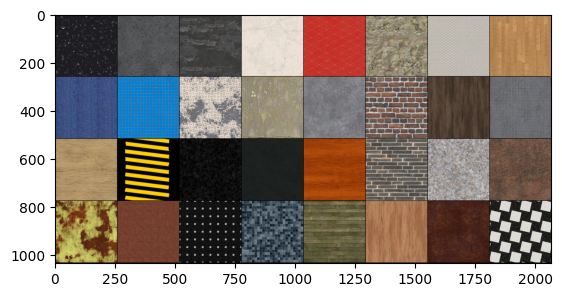

In [ ]:
import matplotlib.pyplot as plt

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

# Remove normalization for visualization
denormalize = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])


grid = torchvision.utils.make_grid(denormalize(image1), nrow=8)
plt.imshow(grid.permute(1, 2, 0))


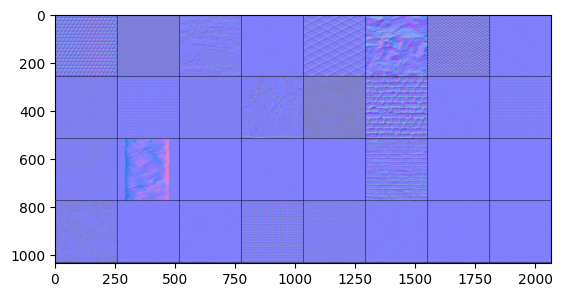

In [ ]:
grid = torchvision.utils.make_grid(denormalize(image2), nrow=8)
plt.imshow(grid.permute(1, 2, 0))

## Pix2Pix


Let's first build the encoder block of the generator, made of convolutional layers with striding of two, followed by a bath normalization layer, and a Learky ReLU activation function.

In [ ]:
import torch.nn as nn

class Encoder_Block(nn.Module):
    def __init__(self, in_channels, out_channels, is_bn=True):
        super(Encoder_Block, self).__init__()
        self.is_bn = is_bn
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(0.2)


    def forward(self, layer_in):
        output = self.conv(layer_in)
        if self.is_bn:
            output = self.bn(output)
        return self.lrelu(output)



Let's test the code

In [ ]:
enc_block = Encoder_Block(in_channels=3, out_channels=64, is_bn=True)
output = enc_block(image1)
print(output.shape)

torch.Size([32, 64, 128, 128])


Let's now define the decoder block. Here, we upsample the image features as well as add (concatenate) the necessary skip connections taht must be made from the encoder to the decoder network, as U-Net architecture.

In [ ]:
class Decoder_Block(nn.Module):
    def __init__(self, in_channels, out_channels, is_dropout=True):
        super(Decoder_Block, self).__init__()

        self.is_dropout = is_dropout

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()


    def forward(self, layer_in, skip_in):
        output = self.deconv(layer_in)
        if self.is_dropout:
            output = self.dropout(output)

        output = torch.cat((output, skip_in), dim=1)
        output = self.relu(output)
        return output



Let's test the code

In [ ]:
a = torch.randn(32, 512, 8, 8)
b = torch.randn(32, 512, 16, 16)

dec_block = Decoder_Block(in_channels=512, out_channels=512, is_dropout=True)
output = dec_block(a, b)
print(output.shape)

torch.Size([32, 1024, 16, 16])


Now that we have constructed the blocks, we can call them multiple times to align the network as per the necessary requirement. Final output activation is tanh as it generates images in the range -1 to 1.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()


        self.e1 = Encoder_Block(3, 64, is_bn=False)
        self.e2 = Encoder_Block(64, 128)
        self.e3 = Encoder_Block(128, 256)
        self.e4 = Encoder_Block(256, 512)
        self.e5 = Encoder_Block(512, 512)
        self.e6 = Encoder_Block(512, 512)
        self.e7 = Encoder_Block(512, 512)

        # bottleneck, no batchnorm and relu
        self.b = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False)
        self.relu = nn.ReLU()

        # decoder model
        self.d1 = Decoder_Block(512, 512)
        self.d2 = Decoder_Block(1024, 512)
        self.d3 = Decoder_Block(1024, 512)
        self.d4 = Decoder_Block(1024, 512, is_dropout=False)
        self.d5 = Decoder_Block(1024, 256, is_dropout=False)
        self.d6 = Decoder_Block(512, 128, is_dropout=False)
        self.d7 = Decoder_Block(256, 64, is_dropout=False)

        # output
        self.g = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        e6 = self.e6(e5)
        e7 = self.e7(e6)

        b = self.relu(self.b(e7))


        d1 = self.d1(b, e7)
        d2 = self.d2(d1, e6)
        d3 = self.d3(d2, e5)
        d4 = self.d4(d3, e4)
        d5 = self.d5(d4, e3)
        d6 = self.d6(d5, e2)
        d7 = self.d7(d6, e1)


        output = self.tanh(self.g(d7))

        return output



Let's test it on an image

In [ ]:
netG = Generator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG.to(device)
image1 = image1.to(device)
g_image = netG(image1)
print(g_image.shape)


torch.Size([32, 3, 256, 256])


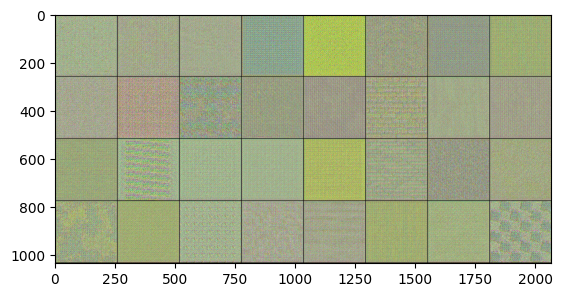

In [ ]:
grid = torchvision.utils.make_grid(denormalize(g_image.cpu()), nrow=8)
plt.imshow(grid.permute(1, 2, 0))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),


            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=False),
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, image_color, image_normal):
        merged = torch.cat((image_color, image_normal), dim=1)
        output = self.layers(merged)
        output = self.sigmoid(output)

        return output.squeeze()



In [ ]:
netD = Discriminator()
netD.to(device)
output = netD(image1.to(device), image2.to(device))

output.shape



torch.Size([32, 15, 15])

In [ ]:
import numpy as np

Great! Our networks seem to work well. Now we can train our Pix2Pix model.

In [ ]:


optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# loss functions
dis_criterion = nn.BCELoss() # discriminator loss
l1_criterion = nn.L1Loss()

num_epochs = 10


dis_label_fake = torch.zeros_like(output, device=device)
dis_label_real = torch.ones_like(output, device=device)

lmbd = 100

d_losses = []
g_losses = []
l1_losses = []

show_every = 10


In [ ]:
for epoch_i in range(num_epochs):
    # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))
        print('Training...')

        store_loss_D = []
        store_loss_G = []
        store_loss_l1 = []

        netD.train()
        netG.train()

        for i, batch in enumerate(dataloader):
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            images_color = batch[0]
            images_normal = batch[1]

            # initialize gradients to zero
            optimizerD.zero_grad()
            optimizerG.zero_grad()

            ####################################
            # Train discriminator on real images
            ####################################

            # pass pair of real images through the discrimninator
            dis_output_real = netD(images_color, images_normal)


            # compute D loss for real images
            dis_real_loss = dis_criterion(dis_output_real, dis_label_real)

            # compute the mean of the discriminator output (between 0 and 1)
            D_x = dis_output_real.cpu().mean()


            ################################################
            # Train discriminator on fake (generated) images
            ################################################

            # generate from a colored image, but no gradient should be computed so we only update the discriminator weights
            with torch.no_grad():
                images_generated = netG(images_color)



            # pass this image through the discriminator along with the real image
            dis_output_fake = netD(images_color, images_generated)

            # ask discriminator to output fake for this pair
            dis_fake_loss = dis_criterion(dis_output_fake, dis_label_fake)

            # backprop both losses to update discriminator
            (dis_real_loss + dis_fake_loss).backward()

            # update weights
            optimizerD.step()

            # compute the mean of the discriminator output (between 0 and 1)
            D_Gz = dis_output_fake.cpu().mean()


            ################################################
            # Train generator on fake (generated) images
            ################################################

            images_generated = netG(images_color)

            # pass this image through the discriminator along with the real image
            dis_output_fake = netD(images_color , images_generated)

            # fool the discriminator into believing that the generated images are real
            gen_fake_loss = dis_criterion(dis_output_fake, dis_label_real)

            # check the L1 loss compared to the real images_normal
            l1_loss = l1_criterion(images_generated, images_normal)

            # backprop through generator
            (gen_fake_loss + l1_loss).backward()

            # update G weights
            optimizerG.step()

            # store batch loss
            store_loss_D.append(dis_real_loss.item() + dis_fake_loss.item())
            store_loss_G.append(gen_fake_loss.item())
            store_loss_l1.append(l1_loss.item())

             # Progress update every x batches.
            if i % show_every == 0 and not i == 0:
                print('[%d/%d][%d/%d]  Loss_D: %.4f  Loss_G: %.4f  Loss_L1: %.4f  D(x): %.4f  D(G(z)): %.4f'
                % (epoch_i, num_epochs, i, len(dataloader),
                    np.mean(store_loss_D), np.mean(store_loss_G), np.mean(store_loss_l1), D_x, D_Gz ))






======== Epoch 1 / 10 ========
Training...


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[0/10][10/44]  Loss_D: 0.4660  Loss_G: 3.8952  Loss_L1: 0.1457  D(x): 0.9742  D(G(z)): 0.1057
[0/10][20/44]  Loss_D: 0.4709  Loss_G: 3.8959  Loss_L1: 0.1441  D(x): 0.3527  D(G(z)): 0.1456
[0/10][30/44]  Loss_D: 0.4478  Loss_G: 3.7959  Loss_L1: 0.1409  D(x): 0.9607  D(G(z)): 0.0959
[0/10][40/44]  Loss_D: 0.3870  Loss_G: 3.9165  Loss_L1: 0.1384  D(x): 0.9668  D(G(z)): 0.0074

======== Epoch 2 / 10 ========
Training...
[1/10][10/44]  Loss_D: 0.1400  Loss_G: 4.4430  Loss_L1: 0.1351  D(x): 0.9272  D(G(z)): 0.0179
[1/10][20/44]  Loss_D: 0.4981  Loss_G: 4.1765  Loss_L1: 0.1365  D(x): 0.9674  D(G(z)): 0.4360
[1/10][30/44]  Loss_D: 0.5407  Loss_G: 3.9238  Loss_L1: 0.1318  D(x): 0.9742  D(G(z)): 0.0693
[1/10][40/44]  Loss_D: 0.5238  Loss_G: 3.9235  Loss_L1: 0.1303  D(x): 0.9478  D(G(z)): 0.0978

======== Epoch 3 / 10 ========
Training...
[2/10][10/44]  Loss_D: 0.3377  Loss_G: 4.2666  Loss_L1: 0.1158  D(x): 0.7987  D(G(z)): 0.0141
[2/10][20/44]  Loss_D: 0.5812  Loss_G: 3.9180  Loss_L1: 0.1197  D(

KeyboardInterrupt: ignored

Let's generate some images to check how they look like

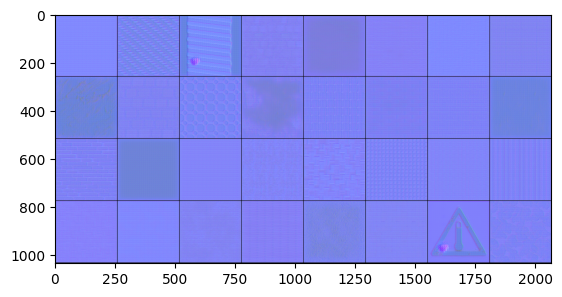

In [ ]:



with torch.no_grad():
    images_generated = netG(images_color.to(device))

grid = torchvision.utils.make_grid(denormalize(images_generated.cpu()), nrow=8)
plt.imshow(grid.permute(1, 2, 0))

Let's compare it to the real normal images from the dataset

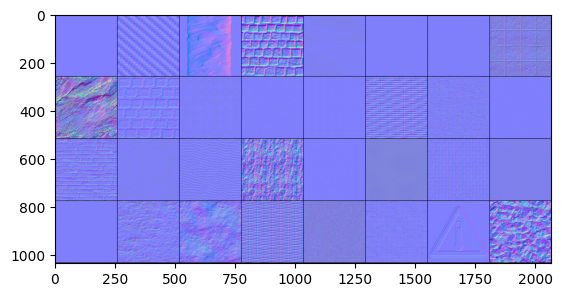

In [ ]:
grid = torchvision.utils.make_grid(denormalize(images_normal.cpu()), nrow=8)
plt.imshow(grid.permute(1, 2, 0))